In [1]:
from pathlib import Path

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import pandas as pd

DATA_PATH = Path("../data")

In [2]:
az.style.use("arviz-white")

In [3]:
earnings = pd.read_csv(DATA_PATH / "earnings.csv")
earnings.head()

,height,weight,male,earn,earnk,ethnicity,education,mother_education,father_education,walk,exercise,smokenow,tense,angry,age
0,74,210.0,1,50000.0,50.0,White,16.0,16.0,16.0,3,3,2.0,0.0,0.0,45
1,66,125.0,0,60000.0,60.0,White,16.0,16.0,16.0,6,5,1.0,0.0,0.0,58
2,64,126.0,0,30000.0,30.0,White,16.0,16.0,16.0,8,1,2.0,1.0,1.0,29
3,65,200.0,0,25000.0,25.0,White,17.0,17.0,NaN,8,1,2.0,0.0,0.0,57
4,63,110.0,0,50000.0,50.0,Other,16.0,16.0,16.0,5,6,2.0,0.0,0.0,91


## Simulating uncertainty for linear predictors and predicted values
### Predict weight (in pounds) from height (in inches)

In [4]:
model_1 = bmb.Model("weight ~ height", data=earnings, dropna=True)
idata_1 = model_1.fit()
az.summary(idata_1, kind="stats")

Automatically removing 27/1816 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weight_sigma, Intercept, height]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,-172.922,11.899,-194.217,-149.535
height,4.944,0.179,4.597,5.263
weight_sigma,28.980,0.489,28.062,29.889


Predict weight for 66 inches person

In [5]:
stats_1 = az.summary(idata_1, kind="stats")["mean"]
predicted_1 = stats_1["Intercept"] + stats_1["height"] * 66
round(predicted_1, 1)

153.4

or

In [6]:
new = pd.DataFrame(dict(height=[66]))
model_1.predict(idata_1, data=new)
predicted_1 = idata_1.posterior["weight_mean"].values.mean()
round(predicted_1, 1)

153.4

### Center heights

In [7]:
earnings["c_height"] = earnings["height"] - 66
model_2 = bmb.Model("weight ~ c_height", data=earnings, dropna=True)
idata_2 = model_2.fit()
az.summary(idata_2, kind="stats")

Automatically removing 27/1816 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weight_sigma, Intercept, c_height]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,153.373,0.698,152.118,154.718
c_height,4.948,0.179,4.628,5.290
weight_sigma,28.961,0.486,28.057,29.855


### Point prediction

In [8]:
new = pd.DataFrame(dict(c_height=[4]))
model_2.predict(idata_2, data=new)
predicted_2 = idata_2.posterior["weight_mean"].values.mean()
round(predicted_2, 1)

173.2

### Posterior simulations

variation coming from posterior uncertainty in the coefficients

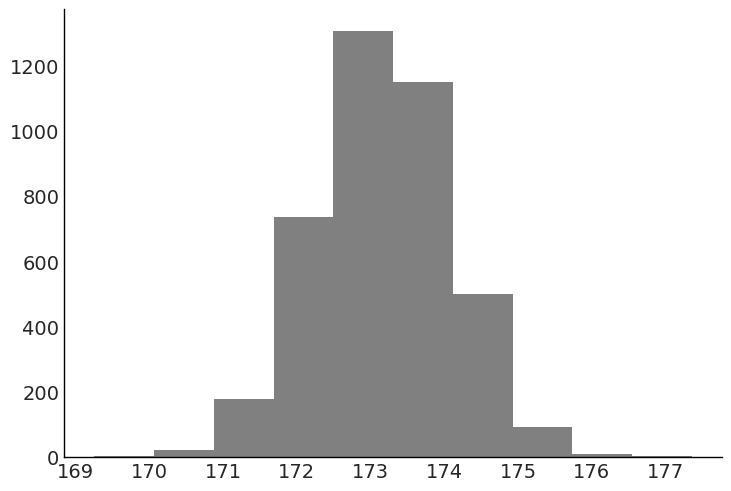

In [9]:
linpred_2 = model_2.predict(idata_2, data=new, inplace=False)
plt.hist(linpred_2.posterior["weight_mean"].values.ravel(), color="gray");

### Posterior predictive simulations
variation coming from posterior uncertainty in the coefficients and predictive uncertainty

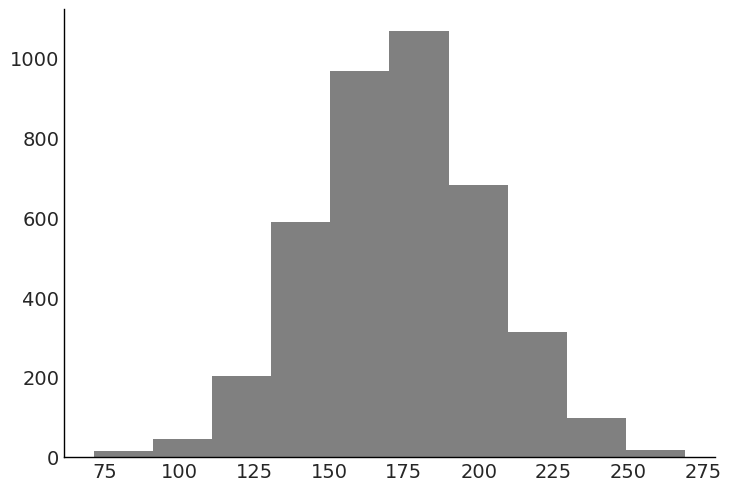

In [10]:
postpred_2 = model_2.predict(idata_2, data=new, kind="pps", inplace=False)
plt.hist(postpred_2.posterior_predictive["weight"].values.ravel(), color="gray");

## Indicator variables
### Predict weight (in pounds) from height (in inches)

In [11]:
new = pd.DataFrame(dict(height=[66]))
pred = model_1.predict(idata_1, data=new, kind="pps", inplace=False)
pred_mean = pred.posterior_predictive["weight"].values.mean()
pred_sd = pred.posterior_predictive["weight"].values.std()
print(
    f"Predicted weight for a 66-inch-tall person is {round(pred_mean)} pounds with a sd of {round(pred_sd)}"
)

Predicted weight for a 66-inch-tall person is 153 pounds with a sd of 29


### Including a binary variable in a regression

In [12]:
model_3 = bmb.Model("weight ~ c_height + male", data=earnings, dropna=True)
idata_3 = model_3.fit()
az.summary(idata_3, kind="stats")

Automatically removing 27/1816 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weight_sigma, Intercept, male, c_height]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,149.530,0.951,147.783,151.342
c_height,3.881,0.253,3.418,4.374
male,11.867,2.028,8.027,15.691
weight_sigma,28.690,0.487,27.762,29.588


In [13]:
new = pd.DataFrame(dict(c_height=[4], male=[0]))
pred = model_3.predict(idata_3, data=new, kind="pps", inplace=False)
pred_mean = pred.posterior_predictive["weight"].values.mean()
pred_sd = pred.posterior_predictive["weight"].values.std()
print(
    f"Predicted weight for a 70-inch-tall female is {round(pred_mean)} pounds with a sd of {round(pred_sd)}"
)

Predicted weight for a 70-inch-tall female is 165 pounds with a sd of 29


### Using indicator variables for multiple levels of a categorical predictor
Include ethnicity in the regression as a factor

In [14]:
model_4 = bmb.Model(
    "weight ~ c_height + male + C(ethnicity)", data=earnings, dropna=True
)
idata_4 = model_4.fit()
az.summary(idata_4, kind="stats")

Automatically removing 27/1816 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weight_sigma, Intercept, C(ethnicity), male, c_height]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,154.356,2.208,150.135,158.402
c_height,3.851,0.252,3.380,4.308
male,12.112,1.988,8.309,15.860
C(ethnicity)[Hispanic],-6.132,3.546,-12.492,0.720
C(ethnicity)[Other],-12.239,5.125,-20.977,-1.720
C(ethnicity)[White],-5.208,2.261,-9.204,-0.890
weight_sigma,28.641,0.467,27.777,29.504


### Choose the baseline category by setting the levels

In [15]:
earnings["eth"] = pd.Categorical(
    earnings["ethnicity"],
    categories=["White", "Black", "Hispanic", "Other"],
    ordered=True,
)
model_5 = bmb.Model("weight ~ c_height + male + eth", data=earnings, dropna=True)
idata_5 = model_5.fit()
az.summary(idata_5, kind="stats")

Automatically removing 27/1816 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weight_sigma, Intercept, eth, male, c_height]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,149.133,0.971,147.309,150.953
c_height,3.857,0.252,3.388,4.334
male,12.077,1.995,8.223,15.741
eth[Black],5.226,2.288,1.105,9.759
eth[Hispanic],-0.924,2.954,-6.332,4.814
eth[Other],-7.173,4.819,-15.649,2.175
weight_sigma,28.656,0.477,27.747,29.518


### Alternatively create indicators for the four ethnic groups directly:

In [16]:
earnings["eth_white"] = earnings["ethnicity"] == "White"
earnings["eth_black"] = earnings["ethnicity"] == "Black"
earnings["eth_hispanic"] = earnings["ethnicity"] == "Hispanic"
earnings["eth_other"] = earnings["ethnicity"] == "Other"

In [17]:
model_6 = bmb.Model(
    "weight ~ c_height + male + eth_black + eth_hispanic + eth_other",
    data=earnings,
    dropna=True,
)
idata_6 = model_6.fit()
az.summary(idata_6, kind="stats")

Automatically removing 27/1816 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weight_sigma, Intercept, eth_other, eth_hispanic, eth_black, male, c_height]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,149.125,0.979,147.387,151.050
c_height,3.851,0.252,3.390,4.330
male,12.120,1.976,8.395,15.663
eth_black,5.191,2.225,1.037,9.428
eth_hispanic,-0.970,2.937,-6.516,4.384
eth_other,-7.013,4.819,-16.082,2.245
weight_sigma,28.656,0.474,27.810,29.576
